<a href="https://colab.research.google.com/github/Nkashyap-anand/human-posture-estimation/blob/main/human_posture_estimation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [4]:
dataset = datasets.ImageFolder('/content/drive/MyDrive/dataset')

In [5]:
data_dir = '/content/drive/MyDrive/dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)

['standing', 'bending', 'sitting', 'lying']
['standing', 'bending', 'sitting', 'lying']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = datasets.ImageFolder('/content/drive/MyDrive/dataset', 
                transform=transforms.ToTensor())

In [8]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([3, 512, 512]) 0


In [9]:
# random_seed = 42
# torch.manual_seed(random_seed)
# set the seed of the random number generator to a fixed value
# so that when you call for example torch.rand(2), the results will be reproducible.

In [10]:
from torch.utils.data import random_split

# 60:20:20 split
train_ds, val_ds, test_ds = random_split(dataset, [2880, 960, 960])
len(train_ds), len(val_ds), len(test_ds)

(2880, 960, 960)

In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size = 16 #start with 64 or 128 and keep doubling it until performance increases 

In [12]:
train_dl = DataLoader(train_ds, 
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                    batch_size,         #can double the batch size because no gradient decent is done here so more memory is free
                    num_workers = 4,
                    pin_memory=True)


# Num_workers tells the data loader instance how many sub-processes to use for data loading. 
# If the num_worker is zero (default) the GPU has to weight for CPU to load data.
# Theoretically, greater the num_workers, more efficiently the CPU load data and less the GPU has to wait.

# pin_memory lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'       
#matplotlib.rcParams contains some properties in matplotlibrc file. We can use it to control the defaults of almost every property in Matplotlib: figure size and DPI, line width, color and style, axes, axis and grid properties, text and font properties and so on.

In [14]:
#from torchvision.utils import make_grid

# Converts a flow to an RGB image. make_grid (tensor[, nrow, padding, …]) Make a grid of images.

# def show_batch(dl):
#   for images, labels in dl:
#     fig, ax = plt.subplots(figsize=(20,10))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
#     break

In [15]:
#show_batch(train_dl)

In [16]:
#show_batch(val_dl)

## Defining the Model (Convolutional Neural Network)

we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
conv = nn.Conv2d(3, 8, kernel_size = 3, stride=1, padding=1)

In [19]:
pool = nn.MaxPool2d(2,2)

In [20]:
# for images, labels in train_dl:
#   print('image.shape: ', images.shape)
#   out = conv(images)
#   print('out.shape', out.shape)
#   out = pool(out)
#   print('out.shape after pooling', out.shape)
#   break

In [21]:
# simple_model = nn.Sequential(
#     nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1),
#     nn.MaxPool2d(2,2)
# )

# The objective of nn. Sequential is to quickly implement sequential modules such that 
# you are not required to write the forward definition, 
# it being implicitly known because the layers are sequentially called on the outputs.

In [22]:
# for images, labels in train_dl:
#   print('image.shape: ', images.shape)
#   out = simple_model(images)
#   print('out.shape', out.shape)
#   break


## Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [24]:
class human_posture_estimation_CNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # output: 3 x 512 x 512
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            # output: 32 x 512 x 512
            nn.ReLU(),
            # output: 32 x 512 x 512
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # output: 64 x 512 x 512
            nn.ReLU(),
            # output: 64 x 512 x 512
            nn.MaxPool2d(2, 2), 
            # output: 64 x 256 x 256

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 128 x 128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 64 x 64

            nn.Flatten(), 
            nn.Linear(256*64*64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)

In [25]:
model = human_posture_estimation_CNN()
model

human_posture_estimation_CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=1048576, out_features=1024, bias=True)
    (17): ReLU()
    (18)

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. 

In [26]:
# for images, labels in train_dl:
#   print('image.shape', images.shape)
#   out = model(images)
#   print('out.shape', out.shape)
#   print('out[0]: ', out[0])
#   break

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

human_posture_estimation_CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=1048576, out_features=1024, bias=True)
    (17): ReLU()
    (18)

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [30]:
from torch.optim import optimizer
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # traiing phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # validation phases
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [31]:
model = to_device(human_posture_estimation_CNN(), device)

In [32]:
evaluate(model, val_dl)

{'val_loss': 1.3864552974700928, 'val_acc': 0.25312501192092896}

In [45]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [44]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

RuntimeError: ignored

In [46]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [47]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [48]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label:  sitting , Predicted sitting


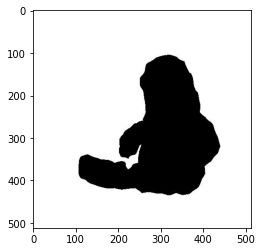

In [52]:
img, label = test_ds[5]
plt.imshow(img.permute(1,2,0))
print('Label: ', dataset.classes[label], ', Predicted', predict_image(img, model))

In [51]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.3874242305755615, 'val_acc': 0.23854166269302368}